# Goal

For now, we are trying to predict the top level product category like Drugs, Counterfeit, Services etc. from listing metadata on the Agora marketplace (2014‑2015).

* Feature sets we will start with  are `origin`, `destination`, `btc price`, vendor `rating/score`, number of `deals` for now.

Models we are using for now are:   

- `Logistic Regression (OvR)` — linear baseline
- `Random Forest Classifier` — non-linear benchmark

Evaluation:

- `Accuracy` and `macro-averaged F1 score` on a 20% test set of the total dataset.
- `5-fold cross-validation` to check for variance and overfitting

# Necessary Imports:


In [1]:
# If running for the first time, uncomment this line:
# %pip install -q kagglehub

import kagglehub
import zipfile, shutil, warnings
from pathlib import Path

# Core
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

%matplotlib inline
sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

# ML Model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Download the dataset from Kaggle
zip_or_dir = kagglehub.dataset_download( "philipjames11/dark-net-marketplace-drug-data-agora-20142015" )
print("Downloaded to:", zip_or_dir)

data_dir = Path("data_agora")
if not data_dir.exists():
    if Path(zip_or_dir).is_dir():
        shutil.copytree(zip_or_dir, data_dir, dirs_exist_ok=True)
    else:
        with zipfile.ZipFile(zip_or_dir, "r") as zf:
            zf.extractall(data_dir)
print("Data import success:", list(data_dir.iterdir()))


/Applications/anaconda3/envs/ml-045/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Downloaded to: /Users/blank/.cache/kagglehub/datasets/philipjames11/dark-net-marketplace-drug-data-agora-20142015/versions/1
Data import success: [PosixPath('data_agora/Agora.csv')]


## Pre-Processing:

Pretty much cleaning up the data to make sure it's useable, and to see its format properly.

In [2]:
# Load Raw CSV -  You could use local .csv file path too if you wanted to.
csv_file = next(data_dir.glob("*.csv"))
print("CSV file:", csv_file.name)

df_raw = pd.read_csv(csv_file, encoding="latin1")
print(f"Rows: {len(df_raw):,} | Cols: {df_raw.shape[1]}")
df_raw.head(3)


CSV file: Agora.csv
Rows: 109,689 | Cols: 9


,Vendor,Category,Item,Item Description,Price,Origin,Destination,Rating,Remarks
0,CheapPayTV,Services/Hacking,12 Month HuluPlus gift Code,12-Month HuluPlus Codes for $25. They are wort...,0.05027025666666667 BTC,Torland,NaN,4.96/5,NaN
1,CheapPayTV,Services/Hacking,Pay TV Sky UK Sky Germany HD TV and much mor...,Hi we offer a World Wide CCcam Service for En...,0.152419585 BTC,Torland,NaN,4.96/5,NaN
2,KryptykOG,Services/Hacking,OFFICIAL Account Creator Extreme 4.2,Tagged Submission Fix Bebo Submission Fix Adju...,0.007000000000000005 BTC,Torland,NaN,4.93/5,NaN


In [3]:
# Making a copy before making changes to the dataset
df = df_raw.copy()

# Initial row count before pre-processing
print(f"Rows starting with: {len(df):,}")

# Column name cleanup - remove spaces and make everything lower‑case overall
df.columns = (df.columns
                .str.strip()
                .str.lower()
                .str.replace(r"\s+", "_", regex=True))

df.info(show_counts=True)

# Origin and destination normalization - Add more later
clean_words = {
    r'\b(worldwide|global|everywhere)\b': 'Worldwide',
    r'\b(united\s*states|^us$|u\.s\.a?)\b': 'USA',
    r'\b(united\s*kingdom|^uk$|britain)\b': 'UK'
}

for col in ('origin', 'destination'):
    df[col] = (df[col].astype(str)
                        .str.lower()                                     # Lower cases it to have less unique set
                        .str.replace(r'[^\w\s]', ' ', regex=True)        # drop punctuation
                        .str.replace(r'\bonly\b', ' ', regex=True)       # Filters hype making words like “only”
                        .str.replace(r'\s+', ' ', regex=True)            # makes sure there's uniform single spacing now
                        .str.strip())
    for pat, repl in clean_words.items():
        df[col] = df[col].str.replace(pat, repl, flags=re.I, regex=True) # Flag makes it case insensitive for replacing, enabling regex.
    df[col] = df[col].str.title()                                        # Making it title like to make the data visually more appealing and consistent




# Price parsing and unit fix

# Remove literal 'BTC' token as they used it a zillion times throughout the set.
df["btc"] = (df["price"].astype(str).str.replace("BTC", "", regex=False).str.strip())       # Pretty much takes the word out from price coln.

# Drop non price stuff
junk_pat = r"[a-zA-Z]{2}|[/]"                                                               # any entry with two consecutive alpha chars or slash "/", as most likely spam
df = df[df["btc"].notna() & ~df["btc"].str.contains(junk_pat)]                              # Keeps rows where the btc coln isn't null or NaN or isn't junk

# Keep listings below 5 BTC for modelling to avoid huge outliers (Can be modified as we see fit)
df["btc"] = pd.to_numeric(df["btc"], errors="coerce")                                       # Converts all entry to numerals, and coerce makes them NaN otherwise.
df = df[df["btc"] < 100]

# Convert btc price in USD at 2014–15 price range. Got data from: https://www.in2013dollars.com/bitcoin-price
# In 2014 it was: 754.22 and in 2015 it was: 314.25. So their avg gives us: 534.24
df["usd"] = (df["btc"] * 534.20).round(2)
df["log_usd"] = np.log1p(df["usd"])



# Rating and deals
# In the dataset, the colns have both the ratings and how many deals the vendors had done. So splitting em.

# Converts everythng to string, so we can do apply regex
tmp = df["rating"].astype(str)

df["score"] = (tmp.str.extract(r"(\d+\.\d+|\d+)/5")[0]       # It matches the first group with any decimal or integer followed by /5
                  .astype(float)) # Makes it a float afterwards

df["deals"] = (tmp.str.extract(r"(\d+)\s*deal")[0]           # Matches the other part of it as # of deals
                  .astype(float))






# Category split
# In our dataset, `category` looks like `"Drugs/RCs/..."`. Since each listing has multipel tags, we are keeping each token as a binary feature in `X` and still let `cat1` be the main `y`.
# So the model predicts overall broad class, while finer tags act as features of the class.


# Split once and keep everything for future use as we see fit
split = df["category"].str.split("/", expand=True)
split.columns = ["cat1", "cat2", "cat3", "cat4"]   # extra cols will be NaN

# Merge into main frame
df = pd.concat([df, split], axis=1)

# Use cat2 and so on as features, down the line. As they are categorical, so the existing OneHotEncoder will handle them.
features = ["score", "deals", "log_usd", "origin", "destination", "cat2"]          # included a sub category as predictive signal
target   = "cat1"

# Final row count after pre-processing
print(f"Rows left: {len(df):,}")



Rows starting with: 109,689
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109689 entries, 0 to 109688
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   vendor            109689 non-null  object
 1   category          109689 non-null  object
 2   item              109685 non-null  object
 3   item_description  109662 non-null  object
 4   price             109684 non-null  object
 5   origin            99807 non-null   object
 6   destination       60528 non-null   object
 7   rating            109674 non-null  object
 8   remarks           12616 non-null   object
dtypes: object(9)
memory usage: 7.5+ MB
Rows left: 109,096


# Data Visualization and Analysis:

Now I will go through some columns that stood out to me and see if we can figure out some stuff that we might be able to research further.

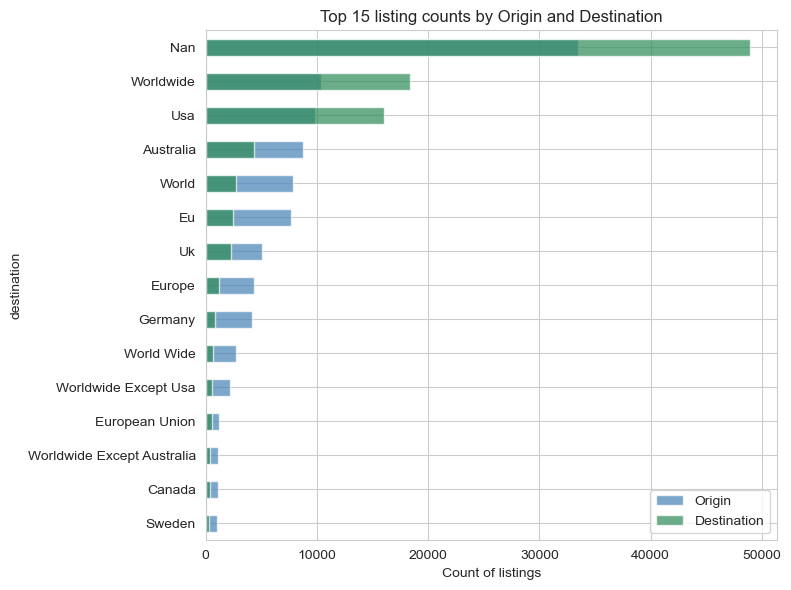


 Top 5 Origins
           count
origin          
Usa        33476
Uk         10337
Nan         9815
Australia   8746
Germany     7830

 Top 5 Destinations
             count
destination       
Nan          48893
Worldwide    18419
Usa          16052
Australia     4323
World         2728


In [4]:
# Look into origin and destination of the products:

# Origin
origin_counts = df.groupby('origin').size().sort_values(ascending=False).head(15)

# Product destination
destination_counts = df.groupby('destination').size().sort_values(ascending=False).head(15)

# Combine the two plots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot origin counts
origin_counts.plot(kind='barh', color='steelblue', alpha=0.7, ax=ax, label='Origin')

# Plot destination counts
destination_counts.plot(kind='barh', color='seagreen', alpha=0.7, ax=ax, label='Destination')

# Customize the plot
ax.invert_yaxis()
ax.set_xlabel('Count of listings')
ax.set_title('Top 15 listing counts by Origin and Destination')
ax.legend()

plt.tight_layout()
plt.show()

# Print the table
print("\n Top 5 Origins")
print(origin_counts.head(5).to_frame(name='count'))

print("\n Top 5 Destinations")
print(destination_counts.head(5).to_frame(name='count'))


### Plot analysis:
Based on the two plots that I just saw, as well as the printed table, it's evident that most product listings come from the USA, with the UK, Australia, and Germany following behind. A noticeable number of listings don’t include origin info. On the destination side, a huge chunk is also missing, which is not surprising given it's a darkweb dataset. From what is listed, many products are shipped worldwide, or specifically to the USA and Australia. This shows the USA is a major player on both ends selling and buying while the missing destination data might just be sellers choosing not to share where they ship, or skipping the detail altogether or straight up lying about it on both cases.

# Building a ML Model:

 Training and Testing sets based on the pre-processing:

## Logistic Regression as base model:

### DO we keep cat2 or nah?

cat2 column (a subcategory) as a predictor. While this feature might overlap semantically with our target cat1, which results in such high precision for base logistic regression model. So testing out base model without it?

-- Looks like I was right, the results dropped significantly. So it seems that our previous excellent performance is driven mostly by structured label information, not deeper inference from price, origin, or vendor stats.

### Logistic Regression Results Analysis:

In our logistic regression model using a one vs rest strategy, through use of Pipeline and ColumnTransfer, achieved strong overall results with an accuracy of `97.8%` and a macro-averaged F1 score of `84.3%`. Categories with high representation in the dataset like `Drugs`, `Services`, and `Data` were classified with almost perfect precision and recall. This suggests that certain features such as `price`, `vendor rating`, and `shipping location` are highly informative for these dominant classes. Also that also tells us that features like `Destination` and `Origin`, or shipping location overall had minimal impact on performance since their values were most likely over generalized to the top 2 or 3 countries and "international" or unknown. I plan to check it next by running the same model, without taking these locations into account for sanity check.

To add on, on the other hand, categories like `Chemicals`, `Jewelry`, and `Electronics` had lower precision and recall, likely due to limited sample sizes and overlapping patterns with other classes.

The printed confusion matrix highlights that most predictions fall along the diagonal, indicating correct classifications, with misclassifications primarily occurring among the less frequent and semantically ambiguous classes. These results support our initial project goal, where we wanted to see whether structured metadata alone can reliably classify major product types in dark web markets. However, to improve predictions for smaller categories, future steps could include integrating text-based features (e.g., `item_description`) or using more flexible models like `Random Forests` or `Gradient Boosting`.

Final usable rows: 109,096
Log. Reg. accuracy: 66.3 %
Log. Reg. F1 macro: 23.799999999999997 %
Log. Reg. F1 Micro: 66.3 %
                    precision    recall  f1-score   support

         Chemicals       0.01      0.39      0.02        18
      Counterfeits       0.32      0.63      0.43       473
              Data       0.28      0.26      0.27       423
Drug paraphernalia       0.06      0.74      0.12       168
             Drugs       0.98      0.72      0.83     18497
       Electronics       0.02      0.15      0.03       119
         Forgeries       0.10      0.23      0.14       210
              Info       0.43      0.42      0.43       433
       Information       0.31      0.54      0.39       369
           Jewelry       0.06      0.67      0.12        84
             Other       0.04      0.01      0.02       284
          Services       0.16      0.11      0.13       527
           Tobacco       0.19      0.49      0.28        84
           Weapons       0.09      0.

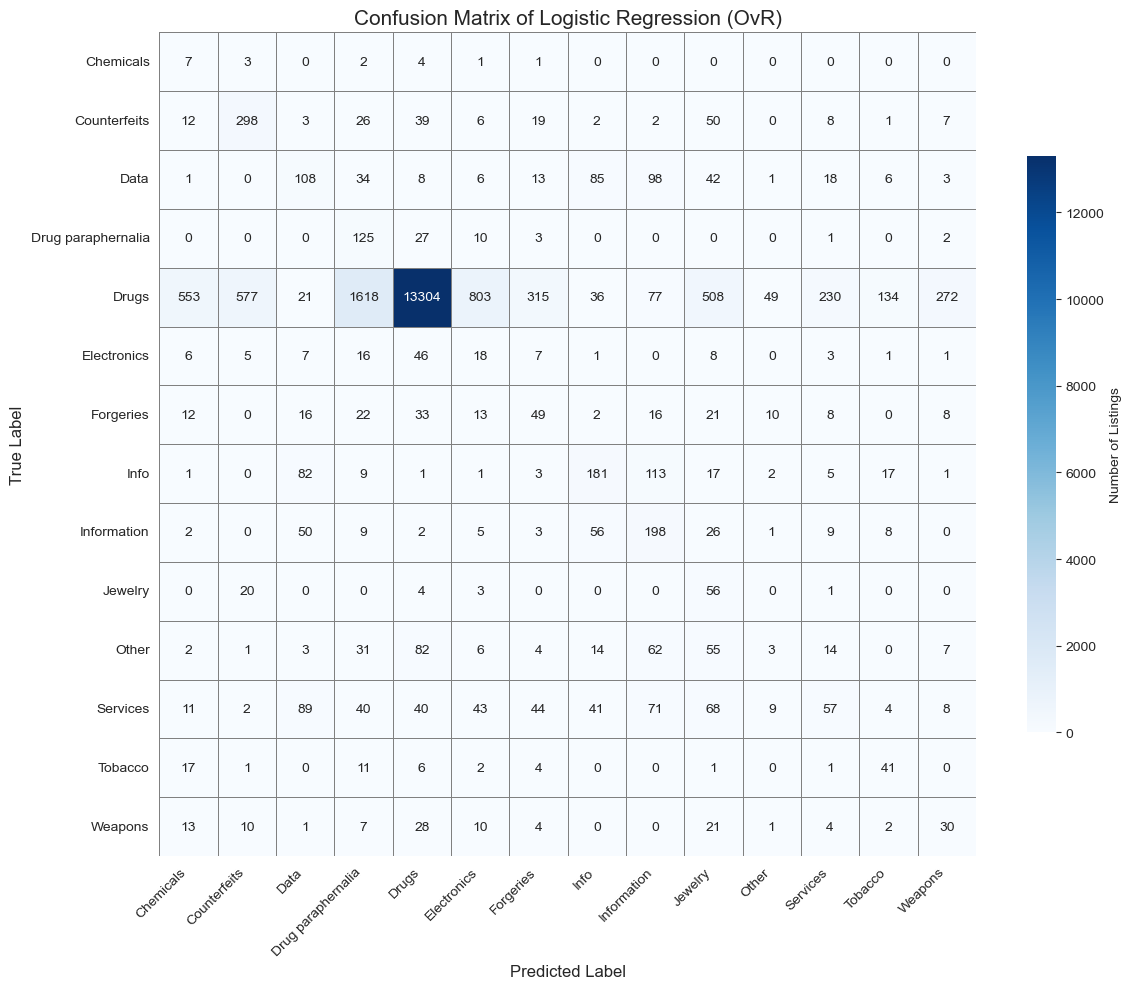

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, classification_report, confusion_matrix)

# Target variable and features
target = "cat1"
features = ["score", "deals", "log_usd", "origin", "destination"]

df_model = df.copy()  # Good practice :))

# Filling missing values
df_model[["origin", "destination"]] = df_model[["origin", "destination"]].fillna("Unknown")

# Keep rows where target is defined
df_model = df_model[df_model[target].notna()]

print(f"Final usable rows: {len(df_model):,}")

# Splits data matrix and vector
X = df_model[features]
y = df_model[target]

# Splitting further into training and testing sets (80-20 rule)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=451, stratify=y
)

# Numeric and categorical groups
num_cols = ["score", "deals", "log_usd"]
cat_cols = ["origin", "destination"]  # Removed cat2

# Preprocessed pipeline to help us later:
prep = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])



# Been reading through the documentation and realized using pipeline would make our life so much easier
# I might be using wrong parameters, so pls do let me know if there's a better one more fitted for our model. https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

log_pipe = Pipeline([("prep", prep),        # Prep refers to the ColnTransformer from our prev. code.
    ("clf",  LogisticRegression(
                max_iter=10000,             # 10k iterations
                # can use "multinomial" and compare
                multi_class="ovr",          # One binary classifier for each class, we used the one vs. rest strategy here.
                solver="lbfgs",             # lbfgs is best for small to medium dataset, which fits our dataset criteria.
                class_weight="balanced",    # Since our dataset is imbalanced based on subclass and class, it adjusts the weights of classes inversely proportional to their frequencies in the data
                C = 0.5))                   # slightly more regularization than default, often improves precision
])

# Fit & evaluate
log_pipe.fit(X_train, y_train)
y_pred_log = log_pipe.predict(X_test)

print("Log. Reg. accuracy:", round(accuracy_score(y_test, y_pred_log), 3)*100, "%")              # Simply, how often our model makes correct predictions. Accuracy fails to take minority class into acc for model eval tho.
print("Log. Reg. F1 macro:", round(f1_score(y_test, y_pred_log, average="macro"), 3)*100, "%")   # with "macro",  F1 score is calculated for each class independently, and their avg is taken, treating all classes equally unlike accuracy.
print("Log. Reg. F1 Micro:", round(f1_score(y_test, y_pred_log, average="micro"), 3)*100, "%")   # with "micro", we aggregates contributions of all class to give a good comparison metric.

# Precision is the proportion of T.P pred out of all pos. pred.
# Recall is T.P pred out of all Pos. instances.
# F1 score formula is: 2 * proportion_of_positive_class / ( 1 + proportion_of_positive_class )
print(classification_report(y_test, y_pred_log))

# Confusion Matrix Plot
labels = sorted(y_test.unique())  # ensures consistent order
cm = confusion_matrix(y_test, y_pred_log, labels=labels)

# Color intensity reflects that number, so darker blue = higher count
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt="d",
    cmap="Blues", xticklabels=labels, yticklabels=labels,
    linewidths=0.4, linecolor='gray', cbar_kws={'shrink': 0.7, 'label': 'Number of Listings'})
plt.title("Confusion Matrix of Logistic Regression (OvR)", fontsize=15)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



### Adding Vendor Feature
Now Based of Vendors, we are going to see if it is a good predicting feature for classification of the different products or services. Lets Try by adding a new Vendor feature now


So in our cleaned dataset df, we created a new numeric feature vendor_activity, which represents the total number of listings posted by each vendor. So now we will update our fetaure list and train our mode again, but this time do it without our score function. This can also show us if teh score column adds/ does not add to the leanring of our model.


- Now that we have split our training and test data we will update our preporcessinga and create our pipeline based of our numeric columns and categorical collumns.
- Finally its time to train and evaluate our model basedo f these new features.
- FIne tuning



# Viewing the best results now based of that.

## Random Forest Classifier:

In [ ]:
# Just replacing the classifier in the same pipeline:
rf_pipe = Pipeline([
    ("prep", prep),
    ("clf", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,            # limit tree depth to avoid overfitting, or just set None
        random_state=451,
        class_weight="balanced",   # handles class imbalance
        n_jobs=-1                  # uses all CPU cores
    ))
])

rf_pipe.fit(X_train, y_train)   
y_pred_rf = rf_pipe.predict(X_test)

print("Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3)*100, "%")
print("Random Forest Macro F1:", round(f1_score(y_test, y_pred_rf, average="macro"), 3)*100, "%")
print("Random Forest Micro F1:", round(f1_score(y_test, y_pred_rf, average="micro"), 3)*100, "%")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 91.0 %
Random Forest Macro F1: 57.8 %
Random Forest Micro F1: 91.0 %
                    precision    recall  f1-score   support

         Chemicals       0.27      0.22      0.24        18
      Counterfeits       0.76      0.70      0.73       473
              Data       0.70      0.64      0.67       423
Drug paraphernalia       0.63      0.55      0.58       168
             Drugs       0.95      0.97      0.96     18497
       Electronics       0.38      0.27      0.32       119
         Forgeries       0.61      0.56      0.58       210
              Info       0.82      0.83      0.82       433
       Information       0.75      0.77      0.76       369
           Jewelry       0.61      0.61      0.61        84
             Other       0.37      0.28      0.32       284
          Services       0.47      0.43      0.45       527
           Tobacco       0.80      0.68      0.74        84
           Weapons       0.32      0.32      0.32       131

     

## We already are getting really good results compared to our base model. I'll now trying to make it such that our hyperparameters are being tuned automatically:

- Using GridSearch CV to do the exhaustive search on behalf of us. Read through the documentation to learn the implementation and parameters.
- Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

# full pipeline
rf_pipe = Pipeline([
    ("prep", prep),  # existing ColumnTransformer
    ("clf", RandomForestClassifier(
        class_weight="balanced",
        random_state=451,
        n_jobs=-1
    ))
])

# Set up grid of hyperparameters to search
'''
Initial search:
param_grid = {
    "clf__n_estimators": [100, 300],       # number of trees
    "clf__max_depth": [10, 20, None],      # limit tree depth
    "clf__min_samples_split": [2, 5],      # when to split a node
    "clf__min_samples_leaf": [1, 2]        # min samples in a leaf node
}
Best Params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}

param_grid = {
    "clf__n_estimators": [300, 600, 900],            # already good at 300; try larger
    "clf__max_depth": [None, 30, 50],                # test whether some limit helps generalization
    "clf__min_samples_split": [2, 5, 10],            # stricter splits to combat overfitting
    "clf__min_samples_leaf": [1, 2, 4]               # test slightly larger leaves
}
# Best Params: {'clf__max_depth': 50, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
# Random Forest Accuracy: 91.10000000000001 %
#Random Forest Macro F1: 58.8 %
'''
param_grid = {
    "clf__n_estimators": [200, 250, 300, 350],            # already good at 300; try larger
    "clf__max_depth": [30, 50, None],                # test whether some limit helps generalization
    "clf__min_samples_split": [1, 2],            # stricter splits to combat overfitting
    "clf__min_samples_leaf": [1]               # test slightly larger leaves
}

# Run the search
grid_search = GridSearchCV(
    # F1 Macro: Treats all samples equally, regardless of class. So good for overall accuracy across the dataset.
    # F1 Micro: Each class matters equally, regardless of size. So better for imbalanced multiclass classification
    rf_pipe, param_grid, cv=3, scoring="f1_macro", n_jobs=-1, verbose=3         # CHange Verbose to 1 or 2 to see more details
)

grid_search.fit(X_train, y_train)

# View best parameters and evaluate on test set
print("Best Params:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_rf = best_model.predict(X_test)

print("Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3)*100, "%")
print("Random Forest Macro F1:", round(f1_score(y_test, y_pred_rf, average="macro"), 3)*100, "%")
#print("Random Forest Micro F1:", round(f1_score(y_test, y_pred_rf, average="micro"), 3)*100, "%")
print(classification_report(y_test, y_pred_rf))


cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[["params", "mean_test_score", "std_test_score"]].head(10)


Best Params: {'clf__max_depth': 50, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Random Forest Accuracy: 91.10000000000001 %
Random Forest Macro F1: 58.8 %
                    precision    recall  f1-score   support

         Chemicals       0.36      0.28      0.31        18
      Counterfeits       0.77      0.71      0.74       473
              Data       0.69      0.65      0.67       423
Drug paraphernalia       0.61      0.58      0.60       168
             Drugs       0.96      0.97      0.96     18497
       Electronics       0.39      0.28      0.33       119
         Forgeries       0.61      0.56      0.58       210
              Info       0.82      0.83      0.82       433
       Information       0.75      0.77      0.76       369
           Jewelry       0.60      0.62      0.61        84
             Other       0.37      0.30      0.33       284
          Services       0.48      0.45      0.47       527
           Tobacco       

,params,mean_test_score,std_test_score
54,"{'clf__max_depth': 50, 'clf__min_samples_leaf'...",0.562431,0.009292
55,"{'clf__max_depth': 50, 'clf__min_samples_leaf'...",0.562156,0.010177
0,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.562131,0.009771
2,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.561697,0.009420
56,"{'clf__max_depth': 50, 'clf__min_samples_leaf'...",0.561664,0.010276
1,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.561555,0.009662
3,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.558504,0.007607
5,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.558183,0.007604
4,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.557903,0.008233
57,"{'clf__max_depth': 50, 'clf__min_samples_leaf'...",0.557190,0.005960


### RFC Result Analysis:

## Feature Importance

## Cross-Validation Snapshot

## Discussion:

# Experimenting (PB):

### Adding Vendor Feature
Now Based of Vendors, we are going to see if it is a good predicting feature for classification of the different products or services. Lets Try by adding a new Vendor feature now

In [ ]:
# Looking at count of vendors
vendor_counts = df["vendor"].value_counts()
#create a new column in the dataframe with the vendor activity
df["vendor_activity"] = df["vendor"].map(vendor_counts)

df[["vendor", "vendor_activity"]].head()


So in our cleaned dataset df, we created a new numeric feature vendor_activity, which represents the total number of listings posted by each vendor. So now we will update our fetaure list and train our mode again, but this time do it without our score function. This can also show us if teh score column adds/ does not add to the leanring of our model.

In [ ]:
# Updated features
features = ["deals", "log_usd", "origin", "destination", "vendor_activity", "vendor"]
target = "cat1"

# Define X and y
X = df[features]
y = df[target]

# Fill missing values if needed
X["origin"] = X["origin"].fillna("Unknown")
X["destination"] = X["destination"].fillna("Unknown")
X["vendor"] = X["vendor"].fillna("Unknown")

# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=451, stratify=y)


Now that we have split our training and test data we will update our preporcessinga and create our pipeline based of our numeric columns and categorical collumns.

In [ ]:
# List of numeric and categorical columns
num_cols = ["deals", "log_usd", "vendor_activity"]
cat_cols = ["origin", "destination", "vendor"]

# Create a preprocessing pipeline
prep = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

Finally its time to train and evaluate our model basedo f these new features.

In [ ]:
# Creating pipeline
log_pipe = Pipeline([
    ("prep", prep),
    ("clf", LogisticRegression(max_iter=1000, multi_class="ovr", class_weight="balanced"))
])

#Fiting teh model
log_pipe.fit(X_train, y_train)

# Predict on the test set
y_pred = log_pipe.predict(X_test)

# printing our Accuracy and F1 score for the new fewature
print("Logistic Regression Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")


FIne tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
# Logistic Regression pipeline
log_pipe = Pipeline([
    ("prep", prep),
    ("clf", LogisticRegression(max_iter=1000, multi_class="ovr", class_weight="balanced"))
])

# Grid of hyperparameters to search
param_grid_log = {
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100]
}

#setting up 5-fold cross-validation
grid_log = GridSearchCV(
    log_pipe,
    param_grid_log,
    cv=5,  # 5-fold cross-validation
    scoring="f1_macro",  #macro F1 score
    n_jobs=-1  # use all cores
)

# Train grid search
grid_log.fit(X_train, y_train)
